In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animals/animals/inf/lion.jpg
/kaggle/input/animals/animals/inf/horse.jpg
/kaggle/input/animals/animals/inf/cat.jpg
/kaggle/input/animals/animals/inf/dog.jpg
/kaggle/input/animals/animals/inf/elephant.jpg
/kaggle/input/animals/animals/val/horse/horse154.png
/kaggle/input/animals/animals/val/horse/horse277.jpg
/kaggle/input/animals/animals/val/horse/horse262.jpg
/kaggle/input/animals/animals/val/horse/horse186.png
/kaggle/input/animals/animals/val/horse/horse223.png
/kaggle/input/animals/animals/val/horse/horse179.png
/kaggle/input/animals/animals/val/horse/horse182.png
/kaggle/input/animals/animals/val/horse/horse257.jpg
/kaggle/input/animals/animals/val/horse/horse196.png
/kaggle/input/animals/animals/val/horse/horse252.png
/kaggle/input/animals/animals/val/horse/horse114.png
/kaggle/input/animals/animals/val/horse/horse96.png
/kaggle/input/animals/animals/val/horse/horse89.png
/kaggle/input/animals/animals/val/horse/horse87.png
/kaggle/input/animals/animals/val/horse/hor

In [2]:
TRAIN_PATH_FOLDER = '/kaggle/input/animals/animals/train'
VALIDATION_PATH_FOLDER = '/kaggle/input/animals/animals/val'

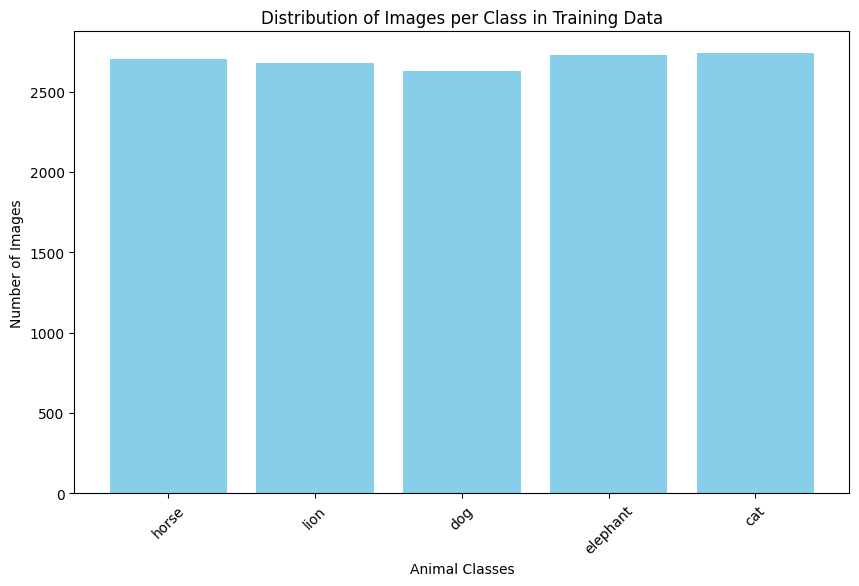

In [3]:
from collections import defaultdict
import matplotlib.pyplot as plt

training_len = defaultdict(int)  
for root, dirs, files in os.walk(TRAIN_PATH_FOLDER):
    if root == TRAIN_PATH_FOLDER:
        continue
    class_name = os.path.basename(root) 
    training_len[class_name] = len(files) 

classes = list(training_len.keys())
counts = list(training_len.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Animal Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class in Training Data')
plt.xticks(rotation=45) 
plt.show()

2024-03-05 04:06:59.849025: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 04:06:59.849114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 04:07:00.057932: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


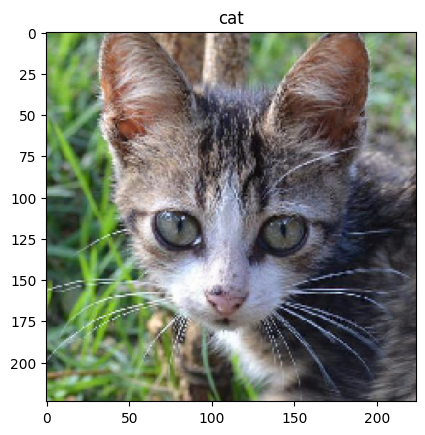

In [4]:
import random
from keras.preprocessing.image import load_img
def show_img(img_path: str, title: str):
  img = load_img(img_path, target_size= (224, 224))
  plt.imshow(img)
  plt.title(title)
  plt.show()
animal = random.choice(classes)
image_name = animal + f"{random.randint(3, 10)}.jpg"
image_path = os.path.join(TRAIN_PATH_FOLDER, animal, image_name)
show_img(image_path, animal)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as Generator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
train_datagen = Generator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH_FOLDER,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode = 'rgb',
    shuffle = True,
)

validation_datagen = Generator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_PATH_FOLDER,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode = 'rgb',
    shuffle = True,
)

Found 13474 images belonging to 5 classes.
Found 1497 images belonging to 5 classes.


In [6]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
base_model = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))  # No pretrained weights
base_model.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = layers.Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, 
              outputs=predictions)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 8,092,229 (30.87 MB)

 Trainable params: 8,008,581 (30.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [8]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
model_name = 'densenet'

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-8,
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath=f'densenet.weights.h5',  # Adjusted filepath to meet requirements
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy','f1_score','precision','recall'])

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(
    train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     validation_steps=validation_generator.samples // validation_generator.batch_size,

    epochs=50,  # You can adjust the number of epochs
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1709611815.682862     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709611815.864986     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.4275 - f1_score: 0.4261 - loss: 1.3448 - precision: 0.5526 - recall: 0.2203

W0000 00:00:1709612140.766465     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709612166.172970     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 2.10426, saving model to densenet.weights.h5
422/422 ━━━━━━━━━━━━━━━━━━━━ 529s 835ms/step - accuracy: 0.4277 - f1_score: 0.4264 - loss: 1.3443 - precision: 0.5528 - recall: 0.2207 - val_accuracy: 0.2318 - val_f1_score: 0.1456 - val_loss: 2.1043 - val_precision: 0.2773 - val_recall: 0.1850 - learning_rate: 1.0000e-04
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.6871 - f1_score: 0.6870 - loss: 0.7968 - precision: 0.7496 - recall: 0.5999
Epoch 2: val_loss improved from 2.10426 to 1.93905, saving model to densenet.weights.h5
422/422 ━━━━━━━━━━━━━━━━━━━━ 172s 402ms/step - accuracy: 0.6872 - f1_score: 0.6871 - loss: 0.7967 - precision: 0.7496 - recall: 0.6000 - val_accuracy: 0.4496 - val_f1_score: 0.3657 - val_loss: 1.9390 - val_precision: 0.5000 - val_recall: 0.4081 - learning_rate: 1.0000e-04
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7511 - f1_score: 0.7498 - loss: 0.6374 - precision: 0.8005 - recall: 

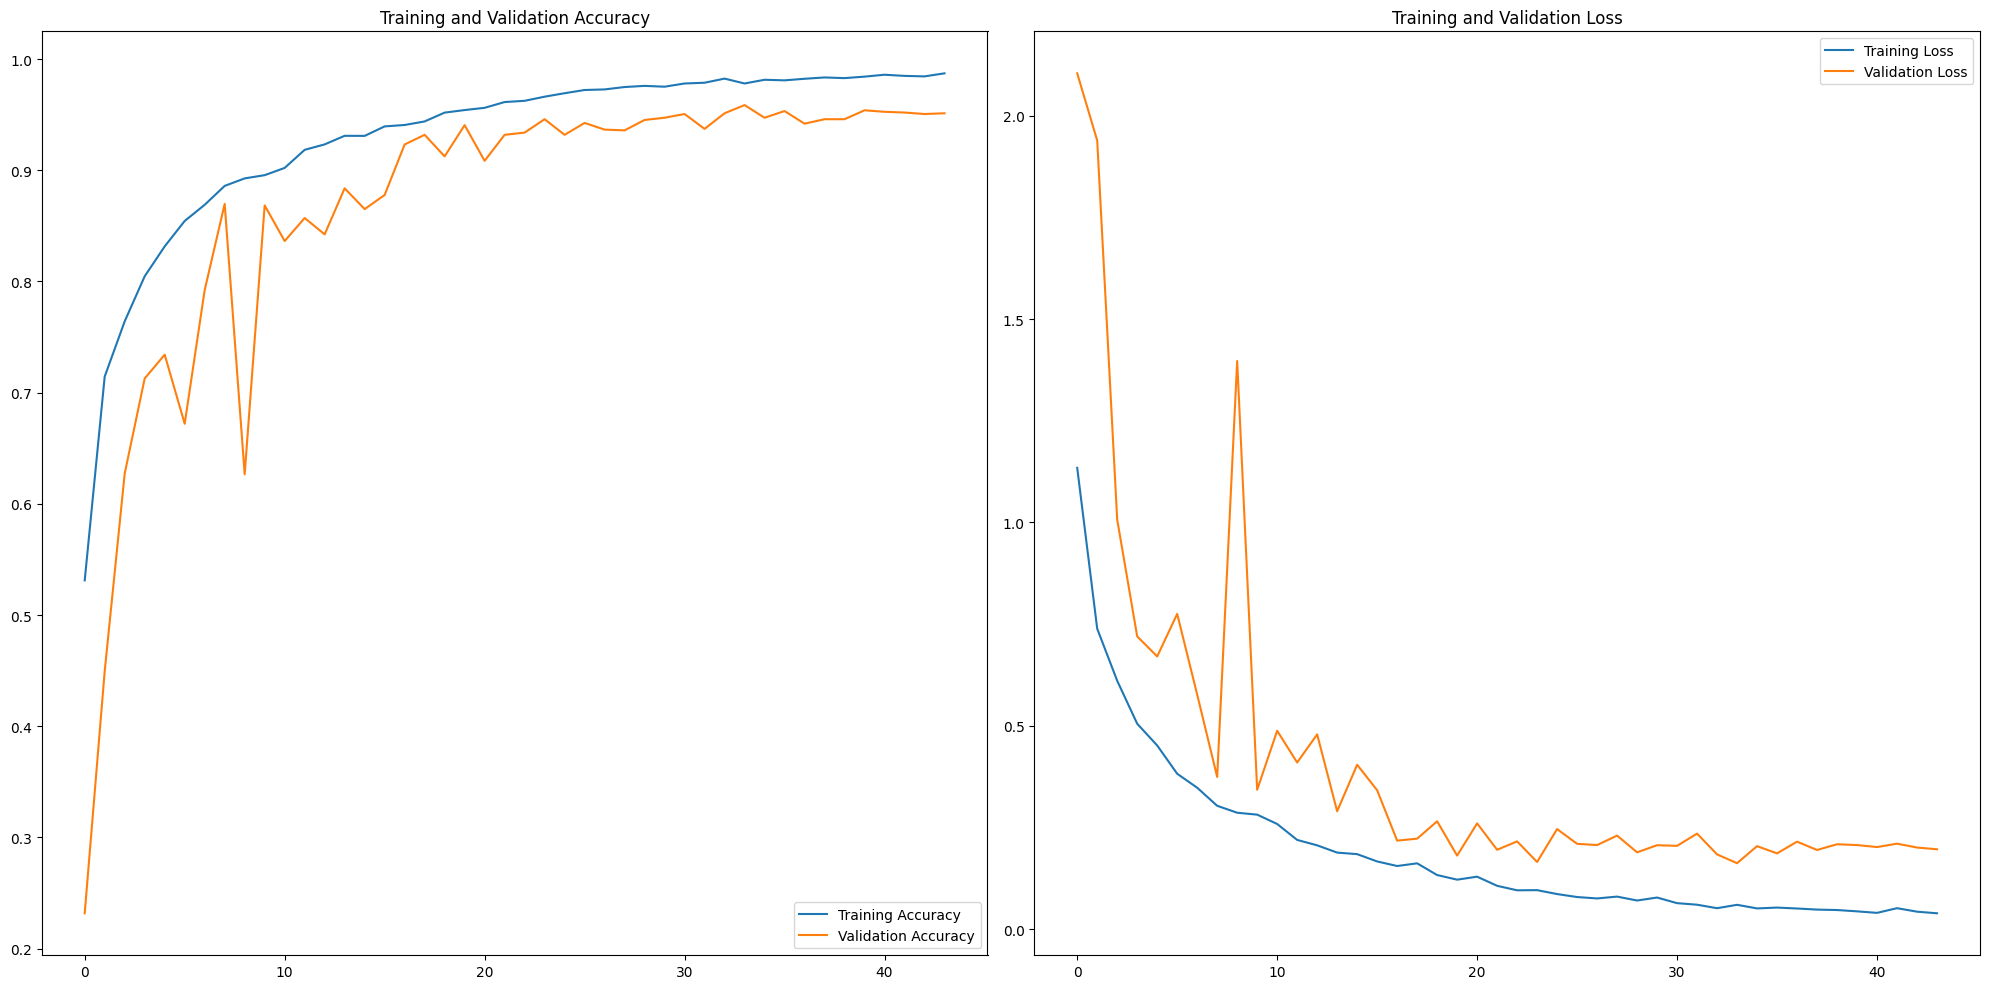

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.savefig('loss_and_accuracy.jpg')

plt.show()

In [10]:
loss, accuracy, f1_score, precision, recall = model.evaluate(validation_generator)
print("Loss: ", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", 2*(precision*recall)/(precision+recall))

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9580 - f1_score: 0.9580 - loss: 0.1592 - precision: 0.9580 - recall: 0.9576
Loss:  0.16411305963993073
Accuracy: 0.9585838317871094
Precision: 0.9585561752319336
Recall: 0.9579158425331116
F1 Score: 0.9582359019083635


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


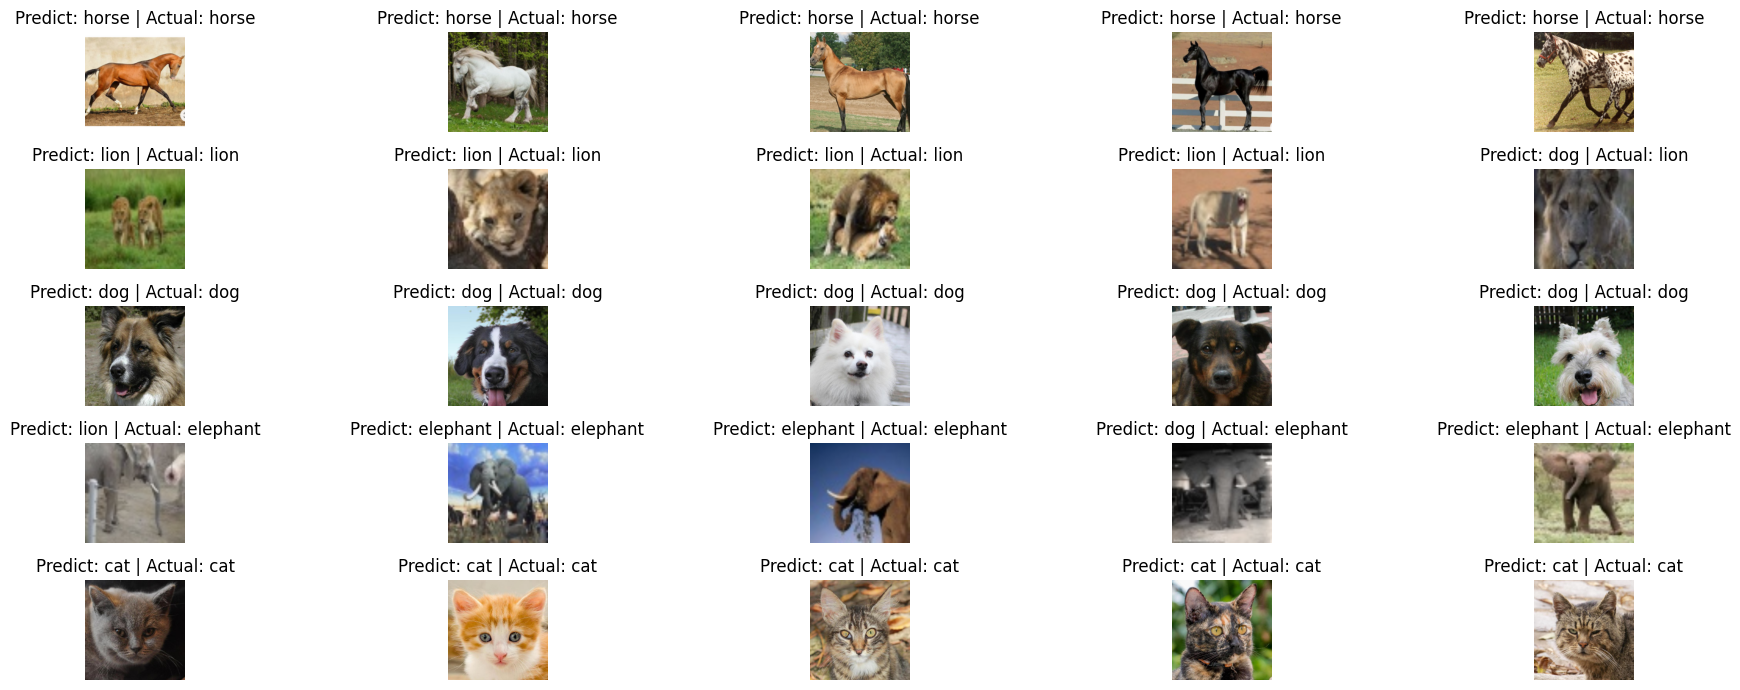

In [12]:
import cv2
def predict(classes, model, base_path, num_images=5, save_fig_path=None):
    fig, axs = plt.subplots(len(classes), num_images, figsize=(20, 7))
    for i, class_name in enumerate(classes):
        class_path = os.path.join(base_path, class_name)
        image_files = os.listdir(class_path)
        random_images = random.sample(image_files, num_images)
        for j, image_file in enumerate(random_images):
            img_path = os.path.join(class_path, image_file)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            image = np.array(image, dtype='float32') / 255.0
            image_to_predict = image.reshape(1, 224, 224, 3)
            prediction = model.predict(image_to_predict).argmax()
            
            label_names = train_generator.class_indices
            dict_class = dict(zip(list(range(len(label_names))), label_names))
            predicted_class_name = dict_class[prediction]
            
            axs[i, j].imshow(image)
            axs[i, j].set_title(f"Predict: {predicted_class_name} | Actual: {class_name}")
            axs[i, j].axis('off')
    plt.tight_layout()
    if save_fig_path is not None:
        plt.savefig(save_fig_path)
    plt.show()

predict(classes, model, VALIDATION_PATH_FOLDER, save_fig_path = 'prediction.jpg')